In [1]:
import re
from tqdm import tqdm_notebook
from google.colab import output
from nltk.corpus import stopwords
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import nltk
from keras.utils.vis_utils import plot_model
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Reading Data

In [2]:
df = pd.read_csv("/content/drive/MyDrive/project_data/fake_or_real_news.csv")
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


Input X is the concatenation of title and text of the news

In [4]:
x = df["title"] + " " + df["text"]
y = pd.get_dummies(df["label"])
y = np.array(y)

# Data Preprocessing

### Data Cleaning


Removing linebreaks, hyperlinks, and having only characters and punctations. Also removing repeated periods and whitespaces

In [5]:
def getCleanText(text):
  text = str(text).replace("\n", "")
  text = str(text).replace(r'[^\.\w\s]','').replace(r'[^\.\w\s]','')
  text = str(text).replace(r'\.\.+','.').replace(r'\.',' . ').replace(r'\s\s+',' ')
  return text

Lower Casing all the text

In [6]:
def lowerCase(text):
  text = re.sub(r'[^\w\s]','',text).lower()
  return text

Removing stopwords using NLTK

In [7]:
def removeStopWords(text):
  output = ""
  text = text.split(" ")
  for word in text:
    if word not in stopwords.words("english"):
      output = output + " " + word
  return str(output.strip())[1:-3].replace(" ", " ")

In [8]:
def preprocess(data):
  texts = [] 
  for line in data:  
    line = getCleanText(line)
    line = lowerCase(line)
    texts.append(removeStopWords(line))
  return texts

In [9]:
texts = preprocess(x)
print('Sample intput data:', texts[0])
print('Sample Label', y[0])

Sample intput data: mell hillarys fear daniel greenfield shillman journalism fellow freedom center new york writer focusing radical islam final stretch election hillary rodham clinton gone war fbi word unprecedented thrown around often election ought retired still unprecedented nominee major political party go war fbi thats exactly hillary people done coma patients waking watching hour cnn hospital beds would assume fbi director james comey hillarys opponent election fbi attack everyone obama cnn hillarys people circulated letter attacking comey currently media hit pieces lambasting targeting trump wouldnt surprising clintons allies start running attack ads fbi fbis leadership warned entire leftwing establishment form lynch mob continue going hillary fbis credibility attacked media democrats preemptively head results investigation clinton foundation hillary clinton covert struggle fbi agents obamas doj people gone explosively public new york times compared comey j edgar hoover bizarre 

### Tokenization

In [10]:
MAX_WORDS = 100000 # maximum number of allowed tokens

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 146511


Adding padding to the data

In [11]:
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding

data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (6335, 1000)
Shape of label tensor: (6335, 2)


## Data Splitting

Data shuffling for randomness

In [12]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

80-20 split (Train/test)

In [13]:
VALIDATION_SPLIT = 0.2 

num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [2531 2537]
validation:  [633 634]


## Word Embedding Using Glove

In [14]:
EMBEDDING_DIMENSION = 100

#DIR: /content/drive/MyDrive/project_data/glove.6B.100d.txt
GLOVE_DIR = "/content/drive/MyDrive/project_data/glove.6B."+str(EMBEDDING_DIMENSION)+"d.txt" 

Creating embeddings_index from GloVe file 

In [15]:
embeddings_index = {}

f = open(GLOVE_DIR, encoding='utf8')
for line in f:
 values = line.split()
 word = values[0]
 embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [16]:
embedding_matrix = np.random.random((146511 + 1, EMBEDDING_DIMENSION))

for word, i in word_index.items():
 embedding_vector = embeddings_index.get(word)
 if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

# Model Definition

Simple RNN

In [17]:
def RNN(embedding_matrix, seq_length = MAX_SEQUENCE_LENGTH, emedding_dim = EMBEDDING_DIMENSION):
  model = Sequential()
  model.add(Input(shape=(seq_length,), dtype='int32'))
  model.add(Embedding(len(word_index) + 1, emedding_dim, weights = [embedding_matrix], 
                      input_length = seq_length, trainable=False, name = 'embeddings'))
  model.add(SimpleRNN(60, return_sequences=True,name='rnn_layer'))
  model.add(GlobalMaxPool1D())
  model.add(Dropout(0.1))
  model.add(Dense(50, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(2, activation='sigmoid'))
  return model

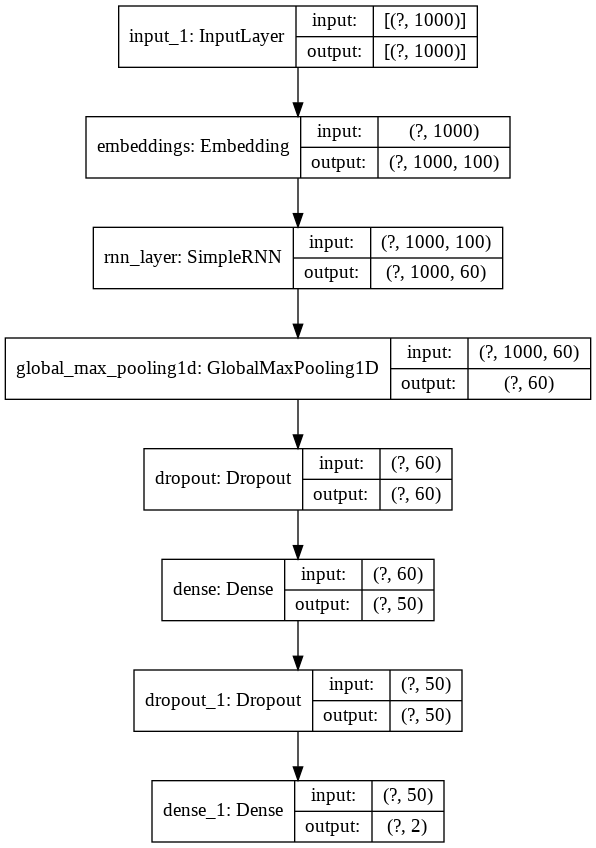

In [18]:
model_rnn = RNN(embedding_matrix)

plot_model(model_rnn, to_file='model_rnn.png', show_shapes=True, show_layer_names=True)

LSTM

In [19]:
def LSTMNet(embedding_matrix, seq_length = MAX_SEQUENCE_LENGTH, emedding_dim = EMBEDDING_DIMENSION):
  model = Sequential()
  model.add(Input(shape=(seq_length,), dtype='int32'))
  model.add(Embedding(len(word_index) + 1, emedding_dim, weights = [embedding_matrix], 
                      input_length = seq_length, trainable=False, name = 'embeddings'))
  model.add(LSTM(60, return_sequences=True,name='lstm_layer'))
  model.add(GlobalMaxPool1D())
  model.add(Dropout(0.1))
  model.add(Dense(50, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(2, activation='sigmoid'))
  return model

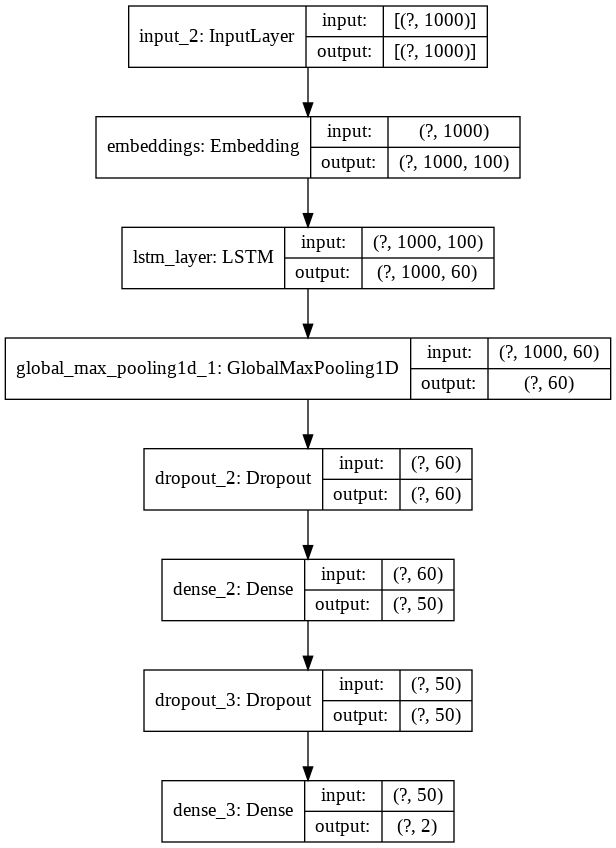

In [20]:
model_lstm = LSTMNet(embedding_matrix)

plot_model(model_lstm, to_file='model_lstm.png', show_shapes=True, show_layer_names=True)

### Training

In [21]:
EPOCHS = 10
BATCH_SIZE = 128

RNN training

In [22]:
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [23]:
rnn_history = model_rnn.fit(x_train, y_train, epochs = EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/10
40/40 [==============================] - 22s 544ms/step - loss: 0.6933 - accuracy: 0.5468 - val_loss: 0.6419 - val_accuracy: 0.7348
Epoch 2/10
40/40 [==============================] - 22s 539ms/step - loss: 0.5867 - accuracy: 0.7072 - val_loss: 0.5023 - val_accuracy: 0.7766
Epoch 3/10
40/40 [==============================] - 23s 563ms/step - loss: 0.4553 - accuracy: 0.7946 - val_loss: 0.4138 - val_accuracy: 0.8208
Epoch 4/10
40/40 [==============================] - 22s 539ms/step - loss: 0.3864 - accuracy: 0.8260 - val_loss: 0.3946 - val_accuracy: 0.8216
Epoch 5/10
40/40 [==============================] - 22s 541ms/step - loss: 0.3316 - accuracy: 0.8627 - val_loss: 0.3251 - val_accuracy: 0.8635
Epoch 6/10
40/40 [==============================] - 22s 542ms/step - loss: 0.2938 - accuracy: 0.8765 - val_loss: 0.3103 - val_accuracy: 0.8658
Epoch 7/10
40/40 [==============================] - 22s 555ms/step - loss: 0.2636 - accuracy: 0.8895 - val_loss: 0.2916 - val_accuracy: 0.8753

LSTM training

In [24]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [25]:
lstm_history = model_lstm.fit(x_train, y_train, epochs = EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Epoch 1/10
40/40 [==============================] - 3s 71ms/step - loss: 0.6378 - accuracy: 0.6470 - val_loss: 0.5113 - val_accuracy: 0.7553
Epoch 2/10
40/40 [==============================] - 2s 59ms/step - loss: 0.4468 - accuracy: 0.8027 - val_loss: 0.3734 - val_accuracy: 0.8500
Epoch 3/10
40/40 [==============================] - 2s 59ms/step - loss: 0.3708 - accuracy: 0.8390 - val_loss: 0.3193 - val_accuracy: 0.8635
Epoch 4/10
40/40 [==============================] - 2s 59ms/step - loss: 0.3129 - accuracy: 0.8706 - val_loss: 0.3310 - val_accuracy: 0.8564
Epoch 5/10
40/40 [==============================] - 2s 59ms/step - loss: 0.2814 - accuracy: 0.8828 - val_loss: 0.2744 - val_accuracy: 0.8863
Epoch 6/10
40/40 [==============================] - 2s 59ms/step - loss: 0.2574 - accuracy: 0.8986 - val_loss: 0.3286 - val_accuracy: 0.8508
Epoch 7/10
40/40 [==============================] - 2s 59ms/step - loss: 0.2282 - accuracy: 0.9098 - val_loss: 0.2504 - val_accuracy: 0.8911
Epoch 8/10
40

## Output Visualization

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def getLoss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  return loss, val_loss

Training and validation loss (Simple RNN)

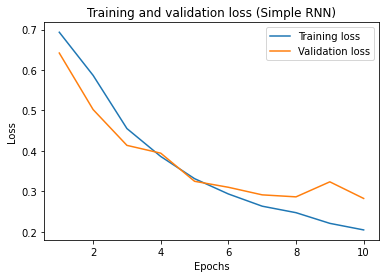

In [27]:
loss, val_loss = getLoss(rnn_history)
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss (Simple RNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

Training and validation loss (LSTM)

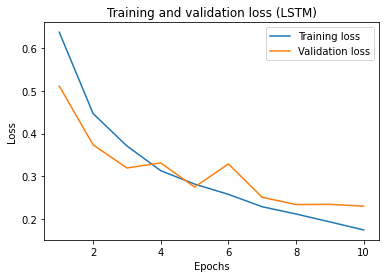

In [28]:
loss, val_loss = getLoss(lstm_history)
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

Accuracy timeline for RNN and LSTM

Training Accuracy: 92.25%
Validation Accuracy: 87.61%


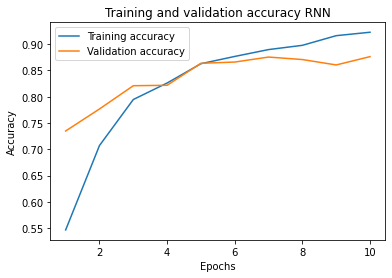

In [29]:
history = rnn_history
print("Training Accuracy: "+ str(round(history.history['accuracy'][-1]*100,2))+"%")
print("Validation Accuracy: "+ str(round(history.history['val_accuracy'][-1]*100,2))+"%")

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy RNN')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

Training Accuracy: 93.0%
Validation Accuracy: 91.16%


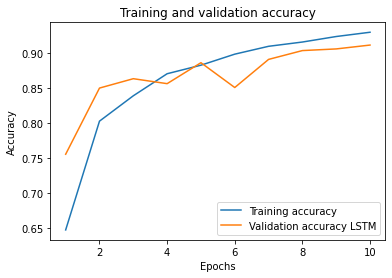

In [30]:
history = lstm_history
print("Training Accuracy: "+ str(round(history.history['accuracy'][-1]*100,2))+"%")
print("Validation Accuracy: "+ str(round(history.history['val_accuracy'][-1]*100,2))+"%")

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy LSTM')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [31]:
lstm_accuracy = {}
lstm_accuracy[100] = round(history.history['val_accuracy'][-1]*100,2)

# Different Embedding Dimesnion

In [32]:
def get_embedding_matrix(embedding_dim = 100):
  embeddings_index = {}

  glove_dir = "/content/drive/MyDrive/project_data/glove.6B."+str(embedding_dim)+"d.txt" 
  f = open(glove_dir, encoding='utf8')
  
  for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
  f.close()
  
  embedding_matrix = np.random.random((146511 + 1, embedding_dim))

  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
  return embedding_matrix

In [33]:
def get_accuracy(embedding_dimension):
  embedding_matrix = get_embedding_matrix(embedding_dimension)
  model = LSTMNet(embedding_matrix, emedding_dim = embedding_dimension)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
  history = model.fit(x_train, y_train, epochs = EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))
  return round(history.history['val_accuracy'][-1]*100,2)

Embedding dimnesion = 50, 100, 200, 300

In [34]:
lstm_accuracy[50] = get_accuracy(50)
output.clear()
lstm_accuracy[200] = get_accuracy(200)
output.clear()
lstm_accuracy[300] = get_accuracy(300)
output.clear()

In [43]:
lstm_accuracy

{50: 89.9, 100: 91.16, 200: 92.03, 300: 92.27}

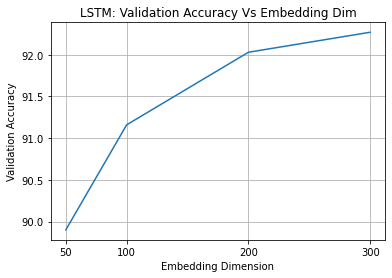

In [44]:
embed_dim = [50,100,200,300]
accuracy = [lstm_accuracy[50],lstm_accuracy[100], lstm_accuracy[200], lstm_accuracy[300]]
plt.plot(embed_dim, accuracy)
plt.title('LSTM: Validation Accuracy Vs Embedding Dim')
plt.xlabel('Embedding Dimension')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.xticks(embed_dim)
plt.show()